In [296]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg

# Introduction

Define some useful constants

Define some helper functions

In [ ]:
def describe

# Loading Data

Import the combined demographic data for the participants

In [310]:
subjects = pd.read_csv("../data/processed/subjects.csv")
subject_ids = ", ".join(repr(str(line)) for line in subjects['SubjectID'])
subjects.set_index('SubjectID', inplace=True)
subjects.index = subjects.index.astype(str)
subjects.head()

,pokemon,OverallScore,QuizScore,Midterm1Score,Midterm2Score,FinalExamScore,FinalExamPart1Score,FinalExamPart2Score,BlockPyEvents,Woman,...,Project3Score,Project4Score,FinalProjectScore,FinalDetermineAppropriateDataFlow,FinalIdentifyPrintAsOneWay,FinalEvaluateListDictionaryMisconception,FinalModifyDictionaryAlias,FinalTraceFunctionDefinition,FinalTraceIfStatement,FinalTraceLoop
SubjectID,,,,,,,,,,,,,,,,,,,,,
145,Weezing,92.38,94.87,82.65,96.25,97.45,43.45,54.00,10124,NW,...,15.6,12.6,100.0,3.0,3.0,1.0,3.0,0.75,3.0,3.0
104,Giratina,96.63,99.79,95.50,92.58,96.10,42.10,54.00,8637,NW,...,19.6,57.6,100.0,3.0,3.0,1.0,1.5,1.50,3.0,3.0
258,Glameow,14.43,56.50,0.00,0.00,0.00,0.00,0.00,1993,NW,...,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,Lumineon,99.08,100.00,99.00,97.00,99.00,45.00,54.00,11279,NW,...,19.6,61.8,100.0,3.0,3.0,1.0,3.0,3.00,2.0,3.0
147,Squirtle,60.05,81.30,88.46,76.22,74.92,33.34,41.58,10254,NW,...,2,0.0,0.0,0.0,3.0,0.0,1.5,1.50,3.0,2.0


Load in all the event data from the BlockPy snapshots for just the students

In [79]:
logs = pd.read_sql(f"""
SELECT EventID, SubjectID, AssignmentID, EventType, CodeStateID, ClientTimestamp, ServerTimestamp,
       Score, EditType,
       CompileMessageType, CompileMessageData,
       InterventionCategory, InterventionType, InterventionMessage FROM MainTable
WHERE SubjectID IN ({subject_ids})
""", sqlite3.connect('../data/processed/progsnap2_7.db'),
                   parse_dates=['ServerTimestamp', 'ClientTimestamp'],
                  index_col=['EventID'])
logs.ClientTimestamp = logs.ClientTimestamp.fillna(logs.ServerTimestamp)

In [149]:
END_OF_TERM = logs.ServerTimestamp.max()
END_OF_TERM

Timestamp('2019-12-12 16:50:48.464871')

In [85]:
logs.sample(10)

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage
EventID,,,,,,,,,,,,,
1642252,79,257,File.Edit,386522,2019-10-02 18:05:03.197000,2019-10-02 16:51:09.658716,,GenericEdit,,,,,
1207067,192,81,Compile,210011,2019-09-20 13:13:18.695000,2019-09-20 12:13:19.290904,,,,,,,
1490113,115,107,File.Edit,321646,2019-09-26 15:49:20.711000,2019-09-26 14:49:27.777858,,GenericEdit,,,,,
925280,64,255,File.Edit,111314,2019-09-16 14:06:26.232000,2019-09-16 13:06:27.751209,,GenericEdit,,,,,
1754916,181,108,Intervention,420486,2019-10-07 12:46:23.013000,2019-10-07 11:46:22.544585,,,,,Feedback,Analyzer|Unused Variable,<p>The variable <code>zoo</code> was given a v...
1634225,64,260,File.Edit,382708,2019-10-02 17:12:56.933000,2019-10-02 15:59:03.375226,,GenericEdit,,,,,
2825324,186,292,File.Edit,944546,2019-12-12 15:47:43.147000,2019-12-12 15:47:44.229710,,GenericEdit,,,,,
2817622,170,291,File.Edit,940062,2019-12-12 13:56:14.218000,2019-12-12 13:56:15.285576,,GenericEdit,,,,,
574207,121,12,File.Edit,15602,2019-08-29 11:23:20.162018,2019-08-29 11:23:20.162018,,GenericEdit,,,,,


Load in all the code for the code states for just the students

In [81]:
code_states = ", ".join(repr(line) for line in logs['CodeStateID'].unique())

In [82]:
code = pd.read_sql(f"""
SELECT ID, Filename, Contents FROM CodeState
WHERE ID IN ({code_states})
""", sqlite3.connect('../data/processed/progsnap2_7.db'),
                  index_col=['ID'])
code.Contents = code.Contents.str.decode("utf-8")

In [86]:
code.sample(10)

,Filename,Contents
ID,,
211187,answer.py,from cisc108 import assert_equal\n\n# ... Defi...
411583,answer.py,"def check_courses(courses: int, credits: int) ..."
618272,answer.py,from cisc108 import assert_equal\ndef all_cats...
308385,answer.py,"import cisc108\n\ndef add_positives(x1: int, x..."
669445,answer.py,from cisc108 import assert_equal\ndef get_name...
740844,answer.py,from cisc108 import assert_equal\ndef lookup_t...
203298,answer.py,percipitation = .1\nif pericipitation > .5\n ...
102525,evaluations,20
55563,answer.py,my_favorite_fictional_character = 'sp'\n


Load in all the assignments and their groups

In [228]:
assignments = pd.read_sql(f"""
SELECT LinkAssignment.AssignmentId as AssignmentID,
       LinkAssignment.`X-Name` as AssignmentName,
       LinkAssignmentGroup.`X-Name` as GroupName
FROM LinkAssignment, LinkAssignmentGroup
WHERE LinkAssignment.`X-AssignmentGroup.Ids` = LinkAssignmentGroup.AssignmentGroupId
""", sqlite3.connect('../data/processed/progsnap2_7.db'),
                         index_col=['AssignmentID'])
# Fill in missing data
assignments.loc['273'] = ['Project 4- Crypto Corgi Company']*2
assignments.loc['280'] = ['??? - Monster Mash']*2
assignments.loc['254'] = ['Project 3- Magical Banking']*2
# Load in the due dates from the locks file
lock_dates = pd.read_csv('../data/processed/locks.csv')
assignments = assignments.reset_index().merge(lock_dates, left_on='GroupName', right_on='GroupName').set_index('AssignmentID')
# Kill the stupid timezone
assignments.DueDate = pd.to_datetime(assignments.DueDate, utc=True).dt.tz_convert('America/New_York').dt.tz_localize(None)

In [229]:
assignments.sample(5)

,AssignmentName,GroupName,DueDate
AssignmentID,,,
51,#16.1) Grab the Animal,#16) Programming: String Operations,2019-09-20 23:59:59
170,#43.5) Winsome Wind Sum,#43) Programming: Nested Data,2019-11-01 23:59:59
103,#29.5) Redundant If,#29) Programming: Nesting Blocks,2019-09-30 23:59:59
249,Recursion B) String Distance,Extra) Recursion Practice,NaT
172,#43.7) Sum Dictionary,#43) Programming: Nested Data,2019-11-01 23:59:59


# New Features

Add in the amount of time left in the semester, and until the assignment is due.
Both of these are available as deltas or hours.

In [247]:
# Add in the due dates
logs_with_due = logs.merge(assignments, left_on='AssignmentID', right_index=True)
# Calculate difference between event and the due date
COL_POS = logs.columns.get_loc("EditType")
logs.insert(COL_POS+1, 'DueDelta', logs_with_due.DueDate.subtract(logs_with_due.ClientTimestamp).clip(pd.Timedelta(0)))
logs.insert(COL_POS+2, 'DueHours', logs['DueDelta'].dt.total_seconds()/60/60)

In [261]:
# Calculate difference between event and the due date
logs.insert(COL_POS+3, 'SemesterDelta', (END_OF_TERM - logs.ClientTimestamp))
logs.insert(COL_POS+4, 'SemesterHours', logs['SemesterDelta'].dt.total_seconds()/60/60)

Add in the time spent before the next log entry for this student

In [318]:
# Group all events by subject
logs_grouped_by_subject = logs.sort_values(['SubjectID', 'ServerTimestamp']).groupby(['SubjectID'])
# Calculate difference between adjacent events, bottoming at zero
logs_duration = logs_grouped_by_subject.ServerTimestamp.diff().fillna(pd.Timedelta(seconds=0))
# cap durations to 30 seconds
logs_duration = logs_duration.clip(pd.Timedelta(seconds=0), pd.Timedelta(seconds=30))
# Insert into table
logs.insert(COL_POS+5, 'DurationDelta', logs_duration)
logs.insert(COL_POS+6, 'DurationSeconds', logs_duration.dt.total_seconds())

In [319]:
logs.sample(5)

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,DueDelta,DueHours,SemesterDelta,SemesterHours,DurationDelta,DurationSeconds,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage
EventID,,,,,,,,,,,,,,,,,,,
2230872,217,270,File.Edit,645070,2019-10-18 23:38:42.936,2019-10-18 22:38:43.393107,,GenericEdit,1 days 00:20:17.064000,24.338073,54 days 17:12:05.528871,1313.201536,00:00:01.787252,1.787252,,,,,
1375705,211,94,Compile,274552,2019-09-25 09:25:28.931,2019-09-25 08:25:30.662086,,,2 days 14:34:30.069000,62.575019,78 days 07:25:19.533871,1879.422093,00:00:00.000123,0.000123,,,,,
673694,233,21,Run.Program,42794,2019-09-05 15:57:22.925,2019-09-05 14:57:24.209246,,,11 days 13:23:11.075000,277.386410,98 days 00:53:25.539871,2352.890428,00:00:00,0.000000,,,,,
990572,228,64,File.Edit,132069,2019-09-18 08:35:19.954,2019-09-18 07:35:20.356250,,GenericEdit,2 days 15:24:39.046000,63.410846,85 days 08:15:28.510871,2048.257920,00:00:05.378027,5.378027,,,,,
1942053,79,139,File.Edit,506701,2019-10-11 20:50:50.140,2019-10-11 19:50:51.218609,,GenericEdit,8 days 03:08:09.860000,195.136072,61 days 19:59:58.324871,1483.999535,00:00:19.070678,19.070678,,,,,


Find the total duration of time spent by this student on programming

In [321]:
#total_time_spent.index = total_time_spent.index.astype(int)
subjects['TotalDelta'] = logs.groupby('SubjectID').DurationDelta.sum().rename('TotalDelta')
subjects['TotalHours'] = subjects.TotalDelta.dt.total_seconds()/60/60

In [322]:
subjects.sample(5)

,pokemon,OverallScore,QuizScore,Midterm1Score,Midterm2Score,FinalExamScore,FinalExamPart1Score,FinalExamPart2Score,BlockPyEvents,Woman,...,FinalProjectScore,FinalDetermineAppropriateDataFlow,FinalIdentifyPrintAsOneWay,FinalEvaluateListDictionaryMisconception,FinalModifyDictionaryAlias,FinalTraceFunctionDefinition,FinalTraceIfStatement,FinalTraceLoop,TotalDelta,TotalHours
SubjectID,,,,,,,,,,,,,,,,,,,,,
211,Barbaracle,73.51,92.40,84.70,84.63,90.93,37.47,53.46,19369,NW,...,0.0,0.0,3.0,1.0,3.0,3.0,0.0,3.0,23:24:52.294594,23.414526
105,Shellos,99.52,100.00,96.00,100.00,97.50,43.50,54.00,8932,NW,...,100.0,3.0,3.0,0.0,3.0,1.5,3.0,3.0,11:59:46.049202,11.996125
134,Altaria,92.68,98.28,98.50,98.63,97.77,43.77,54.00,12128,W,...,71.5,3.0,3.0,1.0,3.0,1.5,3.0,3.0,13:12:00.169694,13.200047
238,Haunter,93.67,99.14,96.10,98.67,95.54,41.54,54.00,12020,NW,...,83.0,3.0,3.0,1.0,1.5,1.5,3.0,3.0,18:59:20.521326,18.989034
147,Squirtle,60.05,81.30,88.46,76.22,74.92,33.34,41.58,10254,NW,...,0.0,0.0,3.0,0.0,1.5,1.5,3.0,2.0,12:59:31.678555,12.992133


# Parameter Overwrite

Determine which students have overwritten parameters

In [264]:
from ast_utilities import function_with_reinitialization
parameter_overwrites = code.Contents.apply(function_with_reinitialization)
# Give the column a better name
parameter_overwrites = parameter_overwrites.rename('ParametersOverwritten')
# Turn them into frequencies by replacing False (No overwrites) and None (unparseable)
parameter_overwrites = parameter_overwrites.replace({False: "", None: ""}).map(len)
logs_with_PO = logs.merge(parameter_overwrites, left_on='CodeStateID', right_on='ID')

In [265]:
logs_with_PO.sample(5)

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,DueDelta,DueHours,SemesterDelta,SemesterHours,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage,ParametersOverwritten
1517793,167,292,File.Edit,944522,2019-12-12 15:45:59.544,2019-12-12 15:46:00.584592,,GenericEdit,0 days 08:13:59.456000,8.233182,0 days 01:04:48.920871,1.080256,,,,,,0
790774,158,260,File.Edit,401364,2019-10-03 13:43:30.968,2019-10-03 12:29:19.266340,,GenericEdit,1 days 10:16:28.032000,34.274453,70 days 03:07:17.496871,1683.121527,,,,,,0
736412,227,266,File.Edit,362883,2019-09-30 13:35:35.609,2019-09-30 12:35:35.703031,,GenericEdit,NaT,NaN,73 days 03:15:12.855871,1755.253571,,,,,,0
1140079,112,273,File.Edit,652090,2019-10-20 17:30:42.047,2019-10-20 16:30:45.306408,,GenericEdit,4 days 06:28:17.953000,102.471654,52 days 23:20:06.417871,1271.335116,,,,,,0
1285159,167,275,File.Edit,761761,2019-10-25 22:13:14.073,2019-10-25 21:13:11.706629,,GenericEdit,5 days 01:46:44.927000,121.779146,47 days 18:37:34.391871,1146.626220,,,,,,0


In [266]:
# Take the subset of logs where a parameter is overwritten and they were submitting
only_logs_with_PO = logs_with_PO[(logs_with_PO.ParametersOverwritten>0)&(logs_with_PO.EventType=='Intervention')]

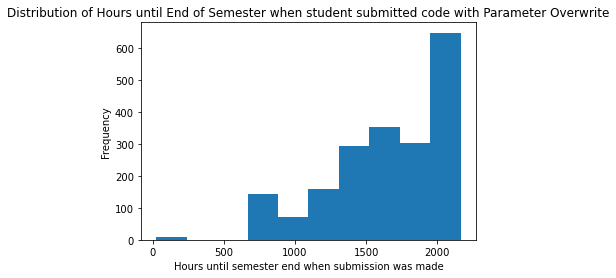

In [267]:
plt.title("Distribution of Hours until End of Semester when student submitted code with Parameter Overwrite")
plt.xlabel("Hours until semester end when submission was made")
only_logs_with_PO.SemesterHours.plot.hist()
plt.show()

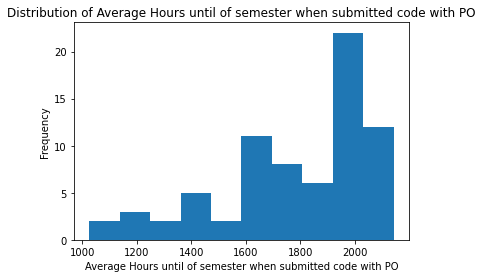

In [284]:
# Group by students and calculate mean hours until semester end
subjects_PO = only_logs_with_PO.groupby('SubjectID').SemesterHours.mean().rename('POSemesterHours')
subjects_PO.index = subjects_PO.index.astype(str)
subjects_PO.plot.hist()
plt.title("Distribution of Average Hours until of semester when submitted code with PO")
plt.xlabel("Average Hours until of semester when submitted code with PO")
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         FinalExamScore   R-squared (uncentered):                   0.637
Model:                            OLS   Adj. R-squared (uncentered):              0.633
Method:                 Least Squares   F-statistic:                              178.8
Date:                Sat, 06 Jun 2020   Prob (F-statistic):                    3.64e-24
Time:                        15:50:44   Log-Likelihood:                         -553.27
No. Observations:                 103   AIC:                                      1109.
Df Residuals:                     102   BIC:                                      1111.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
POSemesterHours     0.0453      0.003     13.372      0.000       0.039       0.052
==============================================================================
Omnibus:                        9.559   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.492
Skew:                           0.553   Prob(JB):                       0.0236
Kurtosis:                       2.276   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

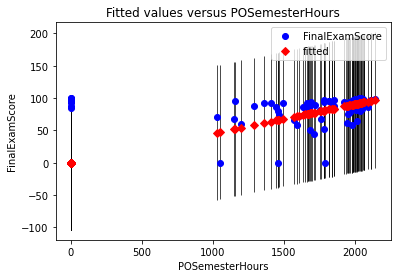

In [314]:
subjects_with_po = subjects.join(subjects_PO)
#subjects_with_po['Overall Score'].corr(subjects_with_po['POSemesterHours'])
results = sm.OLS(subjects_with_po.FinalExamScore, subjects_with_po.POSemesterHours.fillna(0)).fit()
sm.graphics.plot_fit(results, 0)
results.summary()

In [118]:
trajectories = pol[pol.Contents.map(bool)][['SubjectID', 'AssignmentID']].groupby(['SubjectID']).size()

In [120]:
pol_sa = pol[pol.Contents.map(bool)][['SubjectID', 'AssignmentID']].drop_duplicates()

In [129]:
pol

,SubjectID,AssignmentID,EventType,CodeStateID,ClientTimestamp,ServerTimestamp,Score,EditType,CompileMessageType,CompileMessageData,InterventionCategory,InterventionType,InterventionMessage,Contents
0,78,3,File.Create,8,2019-08-26 10:32:53.129817,2019-08-26 10:32:53.129817,,GenericEdit,,,,,,False
1,78,4,File.Create,8,2019-08-26 10:32:53.222696,2019-08-26 10:32:53.222696,,GenericEdit,,,,,,False
2,78,5,File.Create,8,2019-08-26 10:32:53.322646,2019-08-26 10:32:53.322646,,GenericEdit,,,,,,False
3,78,6,File.Create,8,2019-08-26 10:32:53.418887,2019-08-26 10:32:53.418887,,GenericEdit,,,,,,False
4,78,7,File.Create,8,2019-08-26 10:32:53.551331,2019-08-26 10:32:53.551331,,GenericEdit,,,,,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520230,167,293,File.Edit,946191,2019-12-12 16:50:46.483000,2019-12-12 16:50:46.531674,,GenericEdit,,,,,,False
1520231,167,293,Intervention,946191,2019-12-12 16:50:48.302000,2019-12-12 16:50:48.351369,1,,,,Feedback,Complete|Complete,<p>Great work!</p>\n,False
1520232,167,293,Run.Program,946191,2019-12-12 16:50:46.603000,2019-12-12 16:50:48.351445,,,,,,,,False
1520233,167,293,Compile,946191,2019-12-12 16:50:46.484000,2019-12-12 16:50:48.352251,,,,,,,,False


In [126]:
pol_sa_freq = pol_sa.join(assignments, on='AssignmentID').drop_duplicates(['SubjectID', 'GroupName']).groupby("SubjectID").GroupName.count()
pol_sa_freq.index = pol_sa_freq.index.map(int)
pol_sa_freq = pol_sa_freq.rename('ParameterOverwrites')

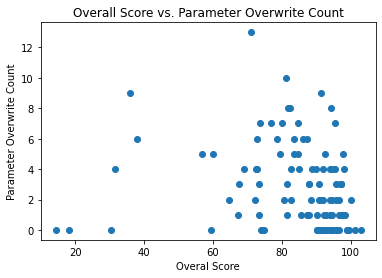

In [128]:
subjects_with_po = subjects.join(pol_sa_freq)
subjects_with_po.ParameterOverwrites = subjects_with_po.ParameterOverwrites.fillna(0)

plt.title("Overall Score vs. Parameter Overwrite Count")
plt.scatter(subjects_with_po['Overall Score'], subjects_with_po['ParameterOverwrites'])
plt.xlabel("Overal Score")
plt.ylabel("Parameter Overwrite Count")
plt.show()

# Spaced/Massed Practice

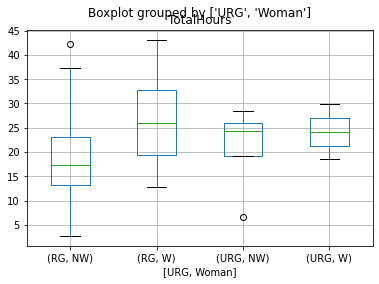

In [23]:
# Hours spent by URG/Gender
subjects.boxplot(column='TotalHours', by=['URG', 'Woman'])

KeyError: 'Column not found: HoursLeft'

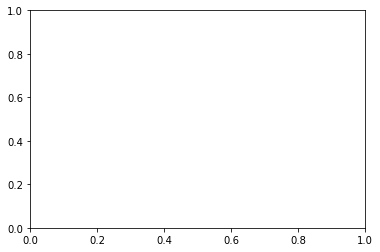

In [31]:
# Hours spent by URG/Gender
subjects.boxplot(column='HoursLeft', by=['URG', 'Woman'])

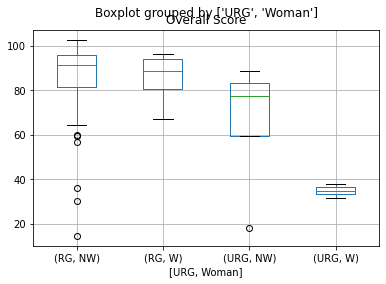

In [26]:
# Overall grade by URG/Gender
subjects.boxplot(column='Overall Score', by=['URG', 'Woman'])

In [49]:
# Add in the due dates
logs_with_due = logs.merge(assignments, left_on='AssignmentID', right_index=True)
# Calculate difference between event and the due date
logs['TimeLeft'] = pd.to_datetime(logs_with_due['Due Date'], utc=True).subtract(logs_with_due.ClientTimestamp).clip(pd.Timedelta(0))
logs['HoursLeft'] = logs['TimeLeft'].dt.total_seconds()/60/60

In [32]:
interventions = logs[logs.EventType == 'Intervention']
time_before_deadlines = interventions.groupby('SubjectID').HoursLeft.mean()
time_before_deadlines.index = time_before_deadlines.index.astype(int)
subjects = subjects.join(time_before_deadlines)

In [43]:
time_before_deadlines = interventions.groupby('SubjectID').HoursLeft.std()
time_before_deadlines.index = time_before_deadlines.index.astype(int)
subjects = subjects.join(time_before_deadlines.rename("HoursDev"))

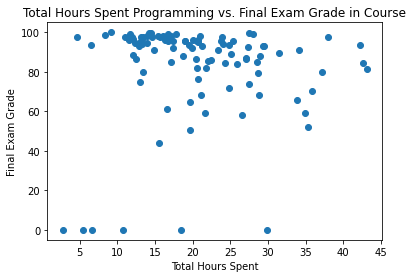

(0.03626181885423827, 0.7161227162256985)

In [40]:
plt.scatter(subjects.TotalHours, subjects['Final Exam Score'])
plt.xlabel("Total Hours Spent")
plt.ylabel("Final Exam Grade")
plt.title("Total Hours Spent Programming vs. Final Exam Grade in Course")
plt.show()

st.pearsonr(subjects.TotalHours, subjects['Final Exam Score'])

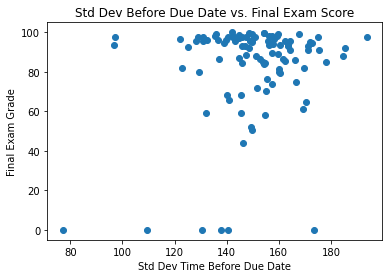

(0.23714723196812415, 0.01586870292536211)
LinregressResult(slope=0.3163407901344741, intercept=35.534439576389865, rvalue=0.23714723196812418, pvalue=0.015868702925362164, stderr=0.12894589039664575)


In [47]:
plt.scatter(subjects.HoursDev, subjects['Final Exam Score'])
plt.xlabel("Std Dev Time Before Due Date")
plt.ylabel("Final Exam Grade")
plt.title("Std Dev Before Due Date vs. Final Exam Score")
plt.show()

print(st.pearsonr(subjects.HoursDev, subjects['Final Exam Score']))
print(st.linregress(subjects.HoursDev, subjects['Final Exam Score']))

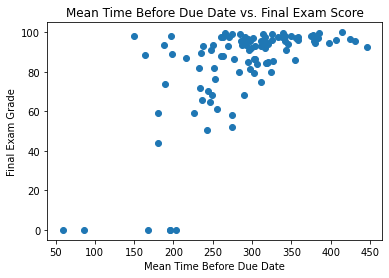

(0.6265448793370334, 1.453541347676737e-12)
LinregressResult(slope=0.21870865605039858, intercept=19.838449616981393, rvalue=0.6265448793370334, pvalue=1.4535413476767333e-12, stderr=0.027071064573878253)


In [42]:
plt.scatter(subjects.HoursLeft, subjects['Final Exam Score'])
plt.xlabel("Mean Time Before Due Date")
plt.ylabel("Final Exam Grade")
plt.title("Mean Time Before Due Date vs. Final Exam Score")
plt.show()

print(st.pearsonr(subjects.HoursLeft, subjects['Final Exam Score']))
print(st.linregress(subjects.HoursLeft, subjects['Final Exam Score']))

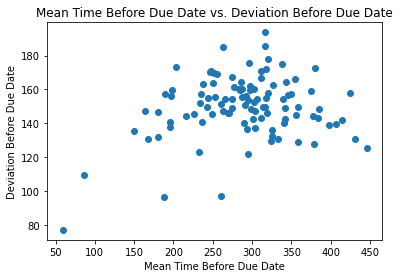

(0.21622476190196552, 0.028258389101379986)
LinregressResult(slope=0.056582493125302814, intercept=133.72051794351478, rvalue=0.21622476190196557, pvalue=0.028258389101379927, stderr=0.025422523346216253)


In [46]:
plt.scatter(subjects.HoursLeft, subjects.HoursDev)
plt.xlabel("Mean Time Before Due Date")
plt.ylabel("Deviation Before Due Date")
plt.title("Mean Time Before Due Date vs. Deviation Before Due Date")
plt.show()

print(st.pearsonr(subjects.HoursLeft, subjects.HoursDev))
print(st.linregress(subjects.HoursLeft, subjects.HoursDev))

In [ ]:
plt.scatter(subjects.HoursLeft, subjects.TotalHours)
plt.xlabel("Hours Left")
plt.ylabel("Total Hours")
plt.show()

st.pearsonr(subjects.HoursLeft, subjects.TotalHours)

# Calculate Average Time Spent Prior

In [48]:
logs

,EventID,Order,SubjectID,AssignmentID,CourseID,EventType,CodeStateID,ParentEventID,ClientTimestamp,ClientTimezone,...,InterventionCategory,InterventionType,InterventionMessage,ServerTimestamp,ServerTimezone,ToolInstances,durations,cappedDurations,TimeLeft,HoursLeft
0,547399,2733,78,3,7,File.Create,8,,NaT,,...,,,,2019-08-26 10:32:53.129817,0500,BPY5,00:00:00,00:00:00,NaT,NaN
1,547400,2734,78,4,7,File.Create,8,,NaT,,...,,,,2019-08-26 10:32:53.222696,0500,BPY5,00:00:00.092879,00:00:00.092879,NaT,NaN
2,547401,2735,78,5,7,File.Create,8,,NaT,,...,,,,2019-08-26 10:32:53.322646,0500,BPY5,00:00:00.099950,00:00:00.099950,NaT,NaN
3,547402,2736,78,6,7,File.Create,8,,NaT,,...,,,,2019-08-26 10:32:53.418887,0500,BPY5,00:00:00.096241,00:00:00.096241,NaT,NaN
4,547403,2737,78,7,7,File.Create,8,,NaT,,...,,,,2019-08-26 10:32:53.551331,0500,BPY5,00:00:00.132444,00:00:00.132444,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447812,2828491,2009529,167,293,7,File.Edit,946191,,2019-12-12 16:50:46.483,300,...,,,,2019-12-12 16:50:46.531674,0500,BPY5,00:00:08.432065,00:00:08.432065,NaT,NaN
1447813,2828492,2009530,167,293,7,Intervention,946191,,2019-12-12 16:50:48.302,300,...,Feedback,Complete|Complete,<p>Great work!</p>\n,2019-12-12 16:50:48.351369,0500,BPY5,00:00:01.819695,00:00:01.819695,NaT,NaN
1447814,2828493,2009531,167,293,7,Run.Program,946191,,2019-12-12 16:50:46.603,300,...,,,,2019-12-12 16:50:48.351445,0500,BPY5,00:00:00.000076,00:00:00.000076,NaT,NaN
1447815,2828494,2009532,167,293,7,Compile,946191,,2019-12-12 16:50:46.484,300,...,,,,2019-12-12 16:50:48.352251,0500,BPY5,00:00:00.000806,00:00:00.000806,NaT,NaN


In [308]:
# The mean of a range times the length of the range, add them all up, divide by the cumulative ranges
